In [4]:
import numpy as np
import sys
sys.path.append('../')
from symmetry_breaking_measure import Nickel, ReflectionOperator
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import pandas as pd

# The violation of symmetry elements of local distorted Nickel

## Sample Size

In [5]:
# Cubic solid cut off from Nickel (length=1)
NUM_SAMPLES = 50000
NUM_D = 50
NUM_ANGLES = 5
CONFIDENCE_LEVEL = .95
TOLERANCE_ONE_SIDE = .0025

nickel = Nickel(cutoff='rectangular_solid', cutout_x=1, cutout_y=1, cutout_z=1)
axis = np.matmul(np.array([0, 0, 1]), nickel._lattice.stdbase)
origin = nickel.xyz.mean(axis=0)
reflection_op = ReflectionOperator(axis=axis, origin=origin)

atoms_idx_in_plane = np.where(nickel.xyz[:,2] == nickel.xyz[:,2].max()/2)[0]
atoms_idx_out_of_plane = np.where(nickel.xyz[:,2] != nickel.xyz[:,2].max()/2)[0]

In [6]:
def perturbation_0_degree(radius=None, num_of_tests=None):
    #phi = np.linspace(0, 2 * np.pi, num_of_tests+1)[:-1]
    phi = np.array([0, np.pi / 4])
    x = np.cos(phi)
    y = np.sin(phi)
    #z = np.zeros(num_of_tests)
    z = np.zeros(2)
    result = np.column_stack((x, y, z)) * radius
    return result

def perturbation_45_degree(radius=None, num_of_tests=None):
    #phi = np.linspace(0, 2 * np.pi, num_of_tests+1)[:-1]
    phi = np.array([0, np.pi / 4])
    factor = np.sqrt(2) / 2
    x = np.cos(phi) * factor
    y = np.sin(phi) * factor
    #z = np.ones(num_of_tests) * factor
    z = np.ones(2) * factor
    result = np.column_stack((x, y, z)) * radius
    return result

def perturbation_90_degree(radius):
    return np.array([[0,0,1]]) * radius

def calc_variance_sample_size_from_nickel(d, idx, perturbation):
    nickel_distorted = Nickel(cutoff='rectangular_solid', cutout_x=1, cutout_y=1, cutout_z=1)
    xyz_distorted = nickel_distorted.xyz
    xyz_distorted[idx,:3] += perturbation * d
    nickel_distorted.set_xyz(xyz_distorted)
    sample_size, measure = nickel_distorted.calc_symmetry_breaking_measure_sample_size(
        num_samples=NUM_SAMPLES,
        operator=reflection_op,
        confidence_interval=CONFIDENCE_LEVEL,
        tolerance_single_side=TOLERANCE_ONE_SIDE,
        method='JS',
        )
    return measure, sample_size

def construct_tasks_sample_size(angle, in_plane, max_d):
    if angle == 0:
        perturbations = perturbation_0_degree(radius=1, num_of_tests=NUM_ANGLES)
    elif angle == 45:
        perturbations = perturbation_45_degree(radius=1, num_of_tests=NUM_ANGLES)
    elif angle == 90:
        perturbations = perturbation_90_degree(radius=1)

    if in_plane:
        atoms_idx_set = atoms_idx_in_plane
    else:
        atoms_idx_set = atoms_idx_out_of_plane
        
    tasks = []
    for d in np.linspace(0,max_d,int(NUM_D*max_d)):
        for idx in atoms_idx_set:
            for perturbation_idx in range(perturbations.shape[0]):
                tasks.append((d, idx, perturbations[perturbation_idx, :]))
    return tasks

def compute_sample_size(args):
    d, idx, perturbation = args
    measure, sample_size = calc_variance_sample_size_from_nickel(d, idx, perturbation)
    return [d, measure, sample_size[0], sample_size[1], sample_size[2]]

def read_sample_size(filedir):
    df = pd.read_csv(filedir, usecols=[0, 2, 3])
    df = df.groupby(df.columns[0]).mean().reset_index()
    result = df.values
    return result

In [7]:
#in-plane atoms
for angle in [0,45,90]:
    tasks = construct_tasks_sample_size(angle=angle, in_plane=True, max_d=4)
    with Pool(processes=cpu_count()) as pool:
        measures_angle = list(tqdm(pool.imap(compute_sample_size, tasks), total=len(tasks)))
    np.savetxt(f'../figs/nickel/reflection_perturbation_{angle}_in_plane_samplesize.csv', np.array(measures_angle), delimiter=',')

100%|██████████| 800/800 [00:16<00:00, 49.77it/s]


In [8]:
#out-of-plane atoms
for angle in [0,45,90]:
    tasks = construct_tasks_sample_size(angle=angle, in_plane=False, max_d=3)
    with Pool(processes=cpu_count()) as pool:
        measures_angle = list(tqdm(pool.imap(compute_sample_size, tasks), total=len(tasks)))
    np.savetxt(f'../figs/nickel/reflection_perturbation_{angle}_out_of_plane_samplesize.csv', np.array(measures_angle), delimiter=',')

100%|██████████| 1500/1500 [00:28<00:00, 53.07it/s]


## Test

In [9]:
def compute_sbm(args):
    idx, d, num_samples, perturbation = args
    nickel_distorted = Nickel(cutoff='rectangular_solid', cutout_x=1, cutout_y=1, cutout_z=1)
    xyz_distorted = nickel_distorted.xyz
    xyz_distorted[idx,:3] += perturbation * d
    nickel_distorted.set_xyz(xyz_distorted)
    measure = nickel_distorted.calc_symmetry_breaking_measure(num_samples=num_samples, operator=reflection_op, method='JS') 
    return [d, measure, idx]

def construct_tasks(angle, in_plane):
    if angle == 0:
        perturbations = perturbation_0_degree(radius=1, num_of_tests=NUM_ANGLES)
    elif angle == 45:
        perturbations = perturbation_45_degree(radius=1, num_of_tests=NUM_ANGLES)
    elif angle == 90:
        perturbations = perturbation_90_degree(radius=1)

    if in_plane:
        atoms_idx_set = atoms_idx_in_plane
    else:
        atoms_idx_set = atoms_idx_out_of_plane
        
    in_plane_str = "in_plane" if in_plane else "out_of_plane"
    sample_sizes = read_sample_size(f'../figs/nickel/reflection_perturbation_{angle}_{in_plane_str}_samplesize.csv')
        
    tasks = []
    for i in range(sample_sizes.shape[0]):
        d = sample_sizes[i,0]
        for idx in atoms_idx_set:
            num_samples = [max(int(sample_sizes[i,1]), 3000), max(int(sample_sizes[i,2]), 3000)]
            for perturbation_idx in range(perturbations.shape[0]):
                tasks.append((idx, d, num_samples, perturbations[perturbation_idx, :]))
    return tasks

In [10]:
#in-plane atoms - 0
angle = 0
tasks = construct_tasks(angle=angle, in_plane=True)
with Pool(processes=cpu_count()) as pool:
    measures = list(tqdm(pool.imap(compute_sbm, tasks), total=len(tasks)))
np.savetxt(f'../figs/nickel/reflection_perturbation_{angle}_in_plane.csv', np.array(measures), delimiter=',')

100%|██████████| 1600/1600 [00:04<00:00, 364.33it/s]


In [11]:
#in-plane atoms - 45
angle = 45
tasks = construct_tasks(angle=angle, in_plane=True)
with Pool(processes=cpu_count()) as pool:
    measures = list(tqdm(pool.imap(compute_sbm, tasks), total=len(tasks)))
np.savetxt(f'../figs/nickel/reflection_perturbation_{angle}_in_plane.csv', np.array(measures), delimiter=',')

100%|██████████| 1600/1600 [00:21<00:00, 73.76it/s]


In [12]:
#in-plane atoms - 90
angle = 90
tasks = construct_tasks(angle=angle, in_plane=True)
with Pool(processes=cpu_count()) as pool:
    measures = list(tqdm(pool.imap(compute_sbm, tasks), total=len(tasks)))
np.savetxt(f'../figs/nickel/reflection_perturbation_{angle}_in_plane.csv', np.array(measures), delimiter=',')

100%|██████████| 800/800 [00:11<00:00, 67.83it/s] 


In [13]:
#out-of-plane atoms - 0
angle = 0
tasks = construct_tasks(angle=angle, in_plane=False)
with Pool(processes=cpu_count()) as pool:
    measures = list(tqdm(pool.imap(compute_sbm, tasks), total=len(tasks)))
np.savetxt(f'../figs/nickel/reflection_perturbation_{angle}_out_of_plane.csv', np.array(measures), delimiter=',')

100%|██████████| 3000/3000 [01:06<00:00, 45.35it/s]


In [14]:
#out-of-plane atoms - 45
angle = 45
tasks = construct_tasks(angle=angle, in_plane=False)
with Pool(processes=cpu_count()) as pool:
    measures = list(tqdm(pool.imap(compute_sbm, tasks), total=len(tasks)))
np.savetxt(f'../figs/nickel/reflection_perturbation_{angle}_out_of_plane.csv', np.array(measures), delimiter=',')

100%|██████████| 3000/3000 [01:02<00:00, 48.34it/s]


In [15]:
#out-of-plane atoms - 90
angle = 90
tasks = construct_tasks(angle=angle, in_plane=False)
with Pool(processes=cpu_count()) as pool:
    measures = list(tqdm(pool.imap(compute_sbm, tasks), total=len(tasks)))
np.savetxt(f'../figs/nickel/reflection_perturbation_{angle}_out_of_plane.csv', np.array(measures), delimiter=',')

100%|██████████| 1500/1500 [00:32<00:00, 46.83it/s]


# Paper Section 5.1.2

In [16]:
import numpy as np
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.image import imread
from bg_mpl_stylesheet.bg_mpl_stylesheet import bg_mpl_style
from symmetry_breaking_measure import Nickel
from colour import Color
from matplotlib import rc

def make_Ramp(ramp_colors): 
    color_ramp = LinearSegmentedColormap.from_list( 'my_list', [ Color( c1 ).rgb for c1 in ramp_colors ] )
    return color_ramp

NUM_SAMPLES = 20000
BLUE, RED, YELLOW, MIDDLE = '#0B3C5D', '#B82601', '#D9B310', '#a8b6c1'

In [17]:
# Load data
# Note: The final data structure will have the form data[angle][in_plane_key][sample_size_key]['x or y or color']
def initialize_data_structure():
    """Initializes the nested dictionary structure for data."""
    return {
        "x": None,
        "y": None,
        "color": None,
    }

data = {}
for angle, color in [[0, BLUE], [45, RED], [90, YELLOW]]:
    data[angle] = {}
    for in_plane_key in ['in_plane', 'out_of_plane']:
        data[angle][in_plane_key] = {}
        for sample_size_key in ['', '_samplesize']:
            data[angle][in_plane_key][sample_size_key] = initialize_data_structure()
            if sample_size_key == '':
                data[angle][in_plane_key][sample_size_key]['x'], data[angle][in_plane_key][sample_size_key]['y'] = np.loadtxt(f'../figs/nickel/reflection_perturbation_{angle}_{in_plane_key}{sample_size_key}.csv', delimiter=',', usecols=(0,1)).T
            else:
                data[angle][in_plane_key][sample_size_key]['x'], data[angle][in_plane_key][sample_size_key]['y'] = np.loadtxt(f'../figs/nickel/reflection_perturbation_{angle}_{in_plane_key}{sample_size_key}.csv', delimiter=',', usecols=(0,4)).T
            data[angle][in_plane_key][sample_size_key]['color'] = color

In [18]:
def make_Ramp(ramp_colors): 
    color_ramp = LinearSegmentedColormap.from_list( 'my_list', [ Color( c1 ).rgb for c1 in ramp_colors ] )
    return color_ramp

def plot(angle_keys, in_plane_key, sample_size_key, xlabel, ylabel, xlim, ylim, filename=None, style=None, text=None, solid=None, extra_data=None):
    fig = plt.figure()
    if style:
        plt.style.use(style)
    fig.set_size_inches(5, 4)
    rc('text', usetex = True) 
    params= {'text.latex.preamble' : r'\usepackage{mathrsfs}'}
    plt.rcParams.update(params)

    ax_main = fig.add_subplot()
    for angle in angle_keys:
        d = data[angle][in_plane_key][sample_size_key]
        ax_main.scatter(d['x'], d['y'], s=1.5, color=d['color'], alpha=0.8)
    ax_main.set_xlim(xlim)
    ax_main.set_ylim(ylim)
    ax_main.set_xlabel(xlabel)
    ax_main.set_ylabel(ylabel)
    
    if extra_data:
        for d in extra_data:
            ax_main.plot(d['x'], d['y'], linestyle=d['linestyle'], color=d['color'], alpha=0.8)

    if text:
        ax_text = fig.add_axes(text['loc'])
        ax_text.text(0, 0, text['content'])
        ax_text.set_axis_off()
        
    if solid:
        img = imread(solid['directory'])
        ax_rectangular_solid = fig.add_axes(solid['loc'])
        ax_rectangular_solid.imshow(img)
        ax_rectangular_solid.set_axis_off()

    plt.show()
    if filename:
        fig.savefig(filename)
        
def plot_solid(lim, in_plane=True, filename=None, style=None):
    # Cubic solid cut off from Nickel (length=1)
    nickel = Nickel(cutoff='rectangular_solid', x=1, y=1, z=1)
    samples = nickel._finite_cluster.generate_samples(NUM_SAMPLES)
    
    fig = plt.figure() 
    ax = fig.add_subplot(projection="3d")
    if style:
        plt.style.use(style)

    cmap_blue = make_Ramp([MIDDLE, BLUE])
    ax = nickel.plot_rectangular_solid(ax=ax, samples=samples, cmap=cmap_blue, facecolor=BLUE, in_plane=in_plane)

    xx, yy = np.meshgrid(np.linspace(0, 3.52, 10), np.linspace(0, 3.52, 10))
    z = np.ones((10,10)) * 1.76
    ax.plot_surface(xx, yy, z, color=BLUE, alpha=.5)

    ax.set_xlim(lim['x'][0],lim['x'][1])
    ax.set_ylim(lim['y'][0],lim['y'][1])
    ax.set_zlim(lim['z'][0],lim['z'][1])
    ax.set_axis_off()

    plt.show()
    if filename:
        fig.savefig(filename)
        
def find_local_minima(angle, in_plane_key, sample_size_key):
    d = data[angle][in_plane_key][sample_size_key]
    diff = np.diff(d['y'])
    idx = np.where((np.hstack([diff, 0]) > 0) & (np.hstack([0, diff]) < 0))[0]
    return d['x'][idx], d['y'][idx]

def find_local_maxima(angle, in_plane_key, sample_size_key):
    d = data[angle][in_plane_key][sample_size_key]
    diff = np.diff(d['y'])
    idx = np.where((np.hstack([diff, 0]) < 0) & (np.hstack([0, diff]) > 0))[0]
    return d['x'][idx], d['y'][idx]

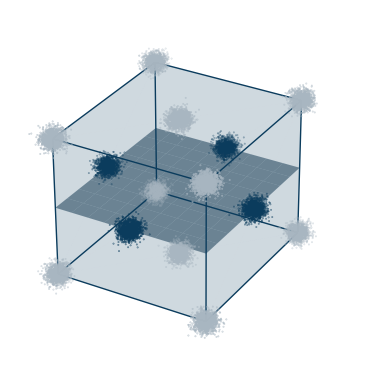

In [4]:
# Cubic solid cut off from Nickel (length=1) - in_plane
lim = {'x': [-0.2,4.5], 'y': [-0.2,4], 'z': [-0.2,3.7]}
plot_solid(lim, in_plane=True, filename='../figs/nickel/cubic_solid_nickel_samples_in_plane_nobackground.png', style=bg_mpl_style)

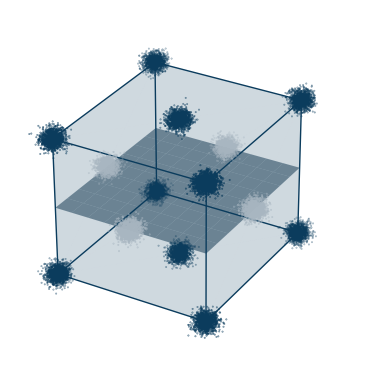

In [5]:
# Cubic solid cut off from Nickel (length=1) - out_of_plane
lim = {'x': [-0.2,4.5], 'y': [-0.2,4], 'z': [-0.2,3.7]}
plot_solid(lim, in_plane=False, filename='../figs/nickel/cubic_solid_nickel_samples_out_of_plane_nobackground.png', style=bg_mpl_style)

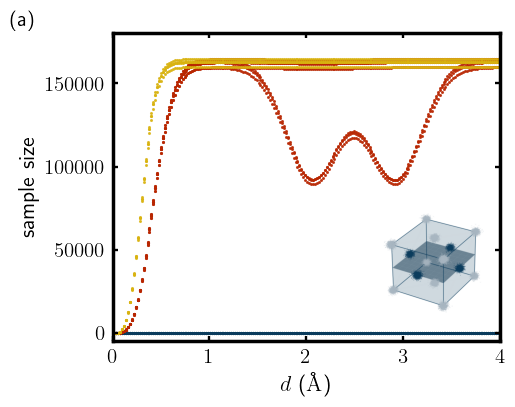

In [19]:
# sample size - in_plane
plot(angle_keys=[0,45,90], in_plane_key='in_plane', sample_size_key='_samplesize', 
     xlabel=r'$d$ ($\mathrm{\AA}$)', ylabel='sample size', xlim=[0,4], ylim=[-5000,180000], 
     filename='../figs/nickel/reflection_in_plane_samplesize.png', style=bg_mpl_style, 
     text={'content':'(a)', 'loc':[-0.08, .9, 0, 0]}, 
     solid={'directory':'../figs/nickel/cubic_solid_nickel_samples_in_plane_nobackground.png', 'loc':[0.64, 0.18, 0.25, 0.25]})

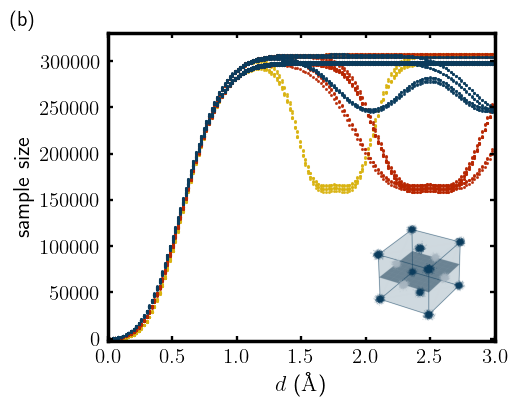

In [20]:
# sample size - out_of_plane
plot(angle_keys=[90, 45 ,0], in_plane_key='out_of_plane', sample_size_key='_samplesize', 
     xlabel=r'$d$ ($\mathrm{\AA}$)', ylabel='sample size', xlim=[0,3], ylim=[-3000,330000], 
     filename='../figs/nickel/reflection_out_of_plane_samplesize.png', style=bg_mpl_style, 
     text={'content':'(b)', 'loc':[-0.07, .9, 0, 0]}, 
     solid={'directory':'../figs/nickel/cubic_solid_nickel_samples_out_of_plane_nobackground.png', 'loc':[0.60, 0.12, 0.32, 0.32]})

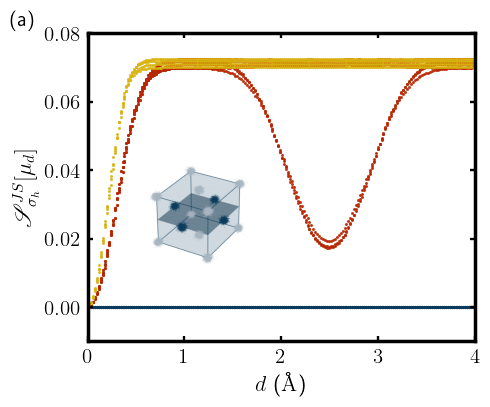

In [21]:
# in-plane
plot(angle_keys=[0,45,90], in_plane_key='in_plane', sample_size_key='', 
     xlabel=r'$d$ ($\mathrm{\AA}$)', ylabel=r'$\mathscr{S}^{JS}_{\sigma_h}[\mu_d]$',
     xlim=[0,4], ylim=[-0.01,0.08], 
     filename='../figs/nickel/reflection_in_plane.png', style=bg_mpl_style, 
     text={'content':'(a)', 'loc':[-0.03, .9, 0, 0]}, 
     solid={'directory':'../figs/nickel/cubic_solid_nickel_samples_in_plane_nobackground.png', 'loc':[0.22, 0.3, 0.25, 0.25]})

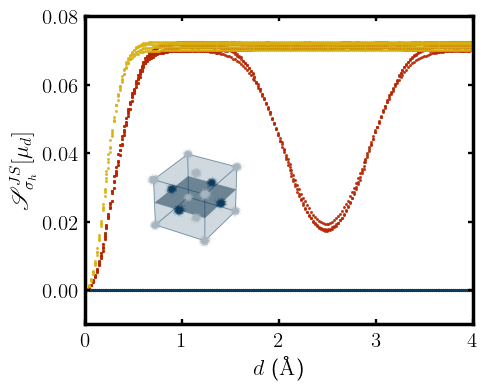

In [22]:
# in-plane no label
plot(angle_keys=[0,45,90], in_plane_key='in_plane', sample_size_key='', 
     xlabel=r'$d$ ($\mathrm{\AA}$)', ylabel=r'$\mathscr{S}^{JS}_{\sigma_h}[\mu_d]$',
     xlim=[0,4], ylim=[-0.01,0.08], 
     filename='../figs/nickel/reflection_in_plane_nolabel.png', style=bg_mpl_style, 
     solid={'directory':'../figs/nickel/cubic_solid_nickel_samples_in_plane_nobackground.png', 'loc':[0.22, 0.3, 0.25, 0.25]})

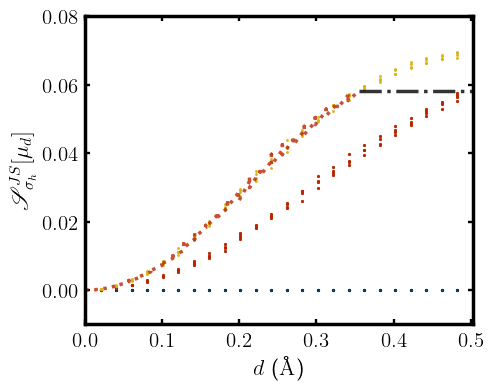

In [24]:
# in-plane - sqrt2
x_max = 200
dx, dy = data[45]['in_plane']['']['x'], data[45]['in_plane']['']['y']
line_1 = {'x':dx[:x_max+1]/np.sqrt(2), 'y':dy[:x_max+1], 'linestyle': ':', 'color': RED}
line_2 = {'x':[dx[x_max]/np.sqrt(2), dx[x_max]], 'y':[dy[x_max],dy[x_max]], 'linestyle': '-.', 'color': 'k'}
extra_data = [line_1, line_2]
plot(angle_keys=[0,45,90], in_plane_key='in_plane', sample_size_key='', 
     xlabel=r'$d$ ($\mathrm{\AA}$)', ylabel=r'$\mathscr{S}^{JS}_{\sigma_h}[\mu_d]$',
     xlim=[0,data[45]['in_plane']['']['x'][x_max]], ylim=[-0.01,0.08], 
     filename='../figs/nickel/reflection_in_plane_sqrt2.png', style=bg_mpl_style, 
     solid=None, extra_data=extra_data)

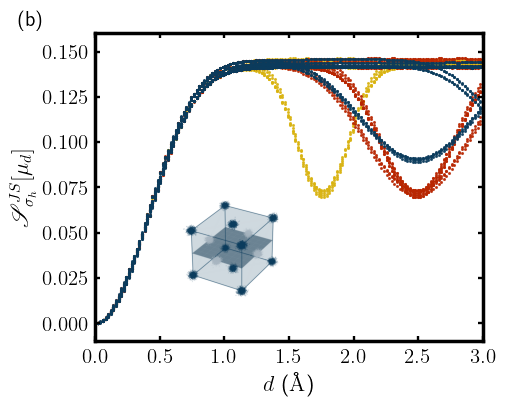

In [25]:
# out-of-plane
plot(angle_keys=[90, 45 ,0], in_plane_key='out_of_plane', sample_size_key='', 
     xlabel=r'$d$ ($\mathrm{\AA}$)', ylabel=r'$\mathscr{S}^{JS}_{\sigma_h}[\mu_d]$',
     xlim=[0,3], ylim=[-0.01,0.16], 
     filename='../figs/nickel/reflection_out_of_plane.png', style=bg_mpl_style, 
     text={'content':'(b)', 'loc':[-0.03, .9, 0, 0]}, 
     solid={'directory':'../figs/nickel/cubic_solid_nickel_samples_out_of_plane_nobackground.png', 'loc':[0.25, 0.18, 0.32, 0.32]})

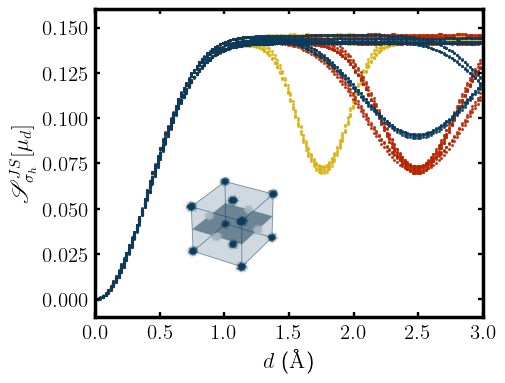

In [26]:
# out-of-plane - nolabel
plot(angle_keys=[90, 45 ,0], in_plane_key='out_of_plane', sample_size_key='', 
     xlabel=r'$d$ ($\mathrm{\AA}$)', ylabel=r'$\mathscr{S}^{JS}_{\sigma_h}[\mu_d]$',
     xlim=[0,3], ylim=[-0.01,0.16], 
     filename='../figs/nickel/reflection_out_of_plane_nolabel.png', style=bg_mpl_style, 
     solid={'directory':'../figs/nickel/cubic_solid_nickel_samples_out_of_plane_nobackground.png', 'loc':[0.25, 0.18, 0.32, 0.32]})